# Using The Super Resolution Convolutional Neural Network for Image Restoration

The goal of super-resolution (SR) is to recover a high resolution image from a low resolution input, or as they might say on any modern crime show, enhance!

To accomplish this goal, we will be deploying the super-resolution convolution neural network (SRCNN) using Keras. This network was published in the paper, "Image Super-Resolution Using Deep Convolutional Networks" by Chao Dong, et al. in 2014. You can read the full paper at https://arxiv.org/abs/1501.00092.

As the title suggests, the SRCNN is a deep convolutional neural network that learns end-to-end mapping of low resolution to high resolution images. As a result, we can use it to improve the image quality of low resolution images. To evaluate the performance of this network, we will be using three image quality metrics: peak signal to noise ratio (PSNR), mean squared error (MSE), and the structural similarity (SSIM) index.

In this particular implementation, we will be using OpenCV to pre and post process our images.We will frequently be converting our images back and forth between the RGB, BGR, and YCrCb color spaces. This is necessary because the SRCNN network is trained on the luminance (Y) channel in the YCrCb color space.

In [40]:
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, PReLU, BatchNormalization, Add, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam
import math
import os
%matplotlib inline

In [41]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
    target_data = np.array(target, dtype=float)
    ref_data = np.array(ref, dtype=float)

    diff = ref_data - target_data
    diff = diff.flatten('C')
    rmse = math.sqrt(np.mean(diff ** 2.))

    if rmse == 0:
        return float('inf')  # Infinite PSNR for perfect match

    return 20 * math.log10(255.0 / rmse)


# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics

def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, win_size=3, channel_axis=-1))  # fix
    return scores


In [17]:
def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = h // factor
        new_width = w // factor
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)



In [18]:
prepare_images('source images/', 2)

Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving GS_S1.jpg
Saving GS_S2.jpg
Saving head_GT.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving rgb_S1.jpg
Saving RGB_S2.jpg
Saving woman_GT.bmp
Saving zebra.bmp


In [20]:
for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source images/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

baboon.bmp
PSNR: 22.157084083442548
MSE: 1187.1161333333334
SSIM: 0.5041131146544947

baby_GT.bmp
PSNR: 34.37180640966199
MSE: 71.28874588012695
SSIM: 0.9033214540499328

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.763458556454362

bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.9248223330738049

butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 648.6254119873047
SSIM: 0.7881072616294768

comic.bmp
PSNR: 23.799861502225532
MSE: 813.2338836565096
SSIM: 0.7317079945068657

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.7289875786300546

flowers.bmp
PSNR: 27.454504805386147
MSE: 350.55093922651935
SSIM: 0.8108826921195051

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270202
SSIM: 0.8957013906644292

GS_S1.jpg
PSNR: 32.51033523068979
MSE: 109.43798611111112
SSIM: 0.9149076414181768

GS_S2.jpg
PSNR: 25.129840644670608
MSE: 598.7114324534161
SSIM: 0.8096531096158088

head_GT.bmp
PSNR: 31.020502848237534
MSE: 154.223775510204

In [21]:
# define the SRCNN model
def SRCNN():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=(9,9), kernel_initializer='glorot_uniform', activation='relu',
                     padding='same', use_bias=True, input_shape=(None, None, 1)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='glorot_uniform', activation='relu',
                     padding='same', use_bias=True))
    
    model.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform', activation='linear',
                     padding='valid', use_bias=True))
    
    adam = Adam(learning_rate=0.0003)

    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model


In [22]:
srcnn = SRCNN()
srcnn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, None, None,     │        10,496 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, None, None, 64) │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, None, None, 1)  │         1,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,889 (335.50 KB)

 Trainable params: 85,889 (335.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img


In [36]:
def predict(image_path):
    srcnn = SRCNN()
    srcnn.load_weights('weights.h5')

    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread(f'source images/{file}')

    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)

    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)

    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0] / 255.

    pre = srcnn.predict(Y, batch_size=1)
    pre = np.clip(pre * 255.0, 0, 255).astype(np.uint8)

    pre = shave(pre[0, :, :, 0], 6)
    temp = shave(temp, 6)

    h, w = pre.shape
    temp = temp[:h, :w, :]
    ref = shave(ref.astype(np.uint8), 6)[:h, :w, :]
    degraded = shave(degraded.astype(np.uint8), 6)[:h, :w, :]

    temp[:, :, 0] = pre
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)

    scores = [
        compare_images(degraded, ref),
        compare_images(output, ref)
    ]

    return ref, degraded, output, scores


1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step
Degraded Image: 
PSNR: 22.26627478756847
MSE: 1157.641632016632
SSIM: 0.5078168130072555

Reconstructed Image: 
PSNR: 17.548046205043743
MSE: 3430.8125896121587
SSIM: 0.21803327057643232



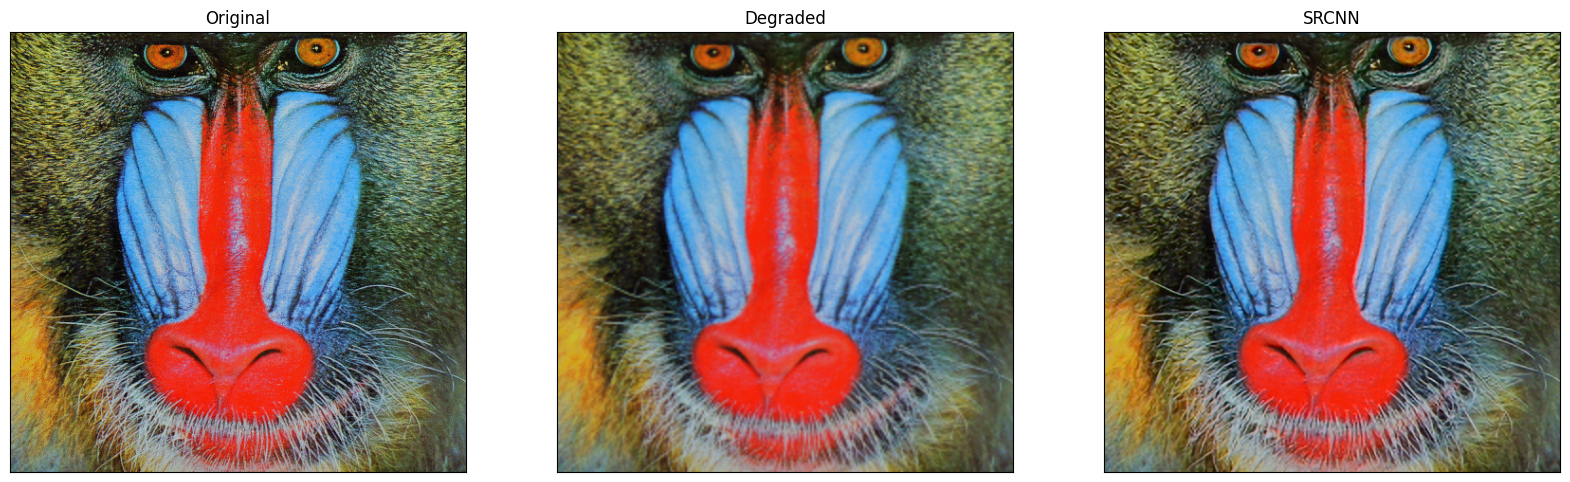

In [37]:
ref, degraded, output, scores = predict('images\\baboon.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [38]:
for file in os.listdir('images'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('images\\{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('Outputs/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
Saving baboon.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step
Saving baby_GT.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 86s 86s/step
Saving barbara.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Saving bird_GT.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Saving butterfly_GT.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Saving comic.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Saving face.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
Saving flowers.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Saving foreman.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 73s 73s/step
Saving GS_S1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 75s 75s/step
Saving GS_S2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Saving head_GT.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step
Saving lenna.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step
Saving monarch.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step
Saving pepper.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 73s 73s/step
Saving ppt3.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 361s 361s/step
Saving rgb_S1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 245s 245s